In [24]:
import os, shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import random
import metrics


random.seed(90)

In [18]:
# original data directories
CT = '../Data/CT/'
MRI = '../Data/MRI/'
PET = '../Data/PET/'

myPaths = [CT, MRI, PET]
myDict={CT:[], MRI:[], PET:[]}

#creo il dizionario con le liste delle immagini
for path in myPaths:
    myDict[path] = [f for f in listdir(path) if isfile(join(path, f))]

#split train test
split_at = 0.8

CT_train, CT_test = train_test_split(myDict[myPaths[0]], train_size=split_at)
MRI_train, MRI_test = train_test_split(myDict[myPaths[1]], train_size=split_at)
PET_train, PET_test = train_test_split(myDict[myPaths[2]], train_size=split_at)

#split train validation
#CT_train, CT_validation = train_test_split(CT_train, train_size=split_at)
#MRI_train, MRI_validation = train_test_split(MRI_train, train_size=split_at)
#PET_train, PET_validation = train_test_split(PET_train, train_size=split_at)

#train e test lists
train_file_names = CT_train + MRI_train + PET_train
#validation = CT_validation + MRI_validation + PET_validation
test_file_names = CT_test + MRI_test + PET_test

#print(train_file_names)

In [35]:
#data/
print('Creo la directory "data/ in questa posizione:', os.getcwd())

directories = ['data/train/', 
               #'data/validation', 
               'data/test/']

#cancello directory precedente per evitare errori
if os.path.exists('data/'):
    shutil.rmtree('data/', ignore_errors=True) 

#creo le direcotories data/train, data/test
for directory in directories:
        os.makedirs(directory)

#copio le immagini di train in data/train
scans = ['CT', 'MRI', 'PET']
for source,scan in zip(myPaths, scans):
    train_files = eval(scan+'_train')
    for f in train_files:
        shutil.copy(source+f, directories[0])
        
#copio le immagini di test in data/test
for source,scan in zip(myPaths, scans):
    test_files = eval(scan+'_test')
    for f in test_files:
        shutil.copy(source+f, directories[1])
        
print("Dati trasferiti con successo in data/train e data/test.")
print("Dimensione database: Training:", len(train_file_names), " Test:", len(test_file_names))

Creo la directory "data/ in questa posizione: /Users/orobix/Documents/Thesis/Source/Code
Dati trasferiti con successo in data/train e data/test.
Dimensione database: Training: 851  Test: 214


Resized images: (218,128) => (128, 128)
Built train tensor and labels (x, y): ( (851, 16384) (851,) )
Number of categories: 3


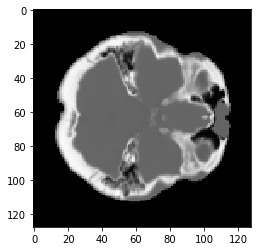

In [82]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

# ***
# TO DO: CONCATENARE ANCHE LE IMMAGINI IN TEST
# ***

# lista per fare image reading
location_train_file_names = [directories[0] + item for item in train_file_names]
#print(location_test_file_names)

#inizialize stack and resise x
x = io.imread(location_train_file_names[random.randint(0,9)])
x = cv2.resize(x, dsize=(128,128))
plt.imshow(x, cmap=plt.cm.gray)
print('Resized images: (218,128) =>', x.shape)

#stack images
for img in location_train_file_names[1:]: #parti dalla seconda immagine
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x = np.dstack((x,img))

#reshape and normalise
x = np.rollaxis(x,-1) #(182,218,N)->(N,182,218)
#x = x.reshape(-1, 128, 128, 1).astype('float32')
x = x/255. 

#make labels y for metrics: CT==0, MRI==1, PET==2
ext = '.png'
y = []
for text in listdir('data/train'):
    fileNameOnly = text[:text.find(ext)]
    y.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
for i, item in enumerate(y):
    if item == 'CT':
        y[i] = '0'
    elif item == 'MRI':
        y[i] = '1'
    else: y[i] = '2'

#reshape and convert x,y for kmeans
x = x.reshape(x.shape[0],-1)
y = np.array([int(i) for i in y])
print('Built train tensor and labels (x, y): (', x.shape, y.shape,')')

#numero di clusters. (3)
n_clusters = len(np.unique(y))
print('Number of categories:', n_clusters)

## Hyper parameters

In [67]:
#to edit
dims = [x.shape[-1], 500, 500, 2000, n_clusters]

# ?
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')

pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 20
batch_size = 16

save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Pretrain a convolutional autoencoder

In [92]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [93]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Autoencoder (1)

In [94]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

In [95]:
def autoencoderConv2D_1(input_shape=(128, 128, 1), filters=[32, 64, 128, 3]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [97]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
embedding (Dense)            (None, 3)                 98307     
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             131072   

### Pretrain


In [108]:
x = x.reshape(-1, 128, 128, 1).astype('float32')
print(x.shape)

(851, 128, 128, 1)


In [109]:
pretrain_epochs = 100
batch_size = 16

In [111]:
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/100
851/851 [==============================] - 10s 12ms/step - loss: 0.0667
Epoch 2/100
624/851 [====================>.........] - ETA: 2s - loss: 0.0573

KeyboardInterrupt: 

In [112]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,outputs=[clustering_layer, autoencoder.output])

ValueError: Layer AE was called with an input that isn't a symbolic tensor. Received type: <class 'int'>. Full input: [16384, 500, 500, 2000, 3]. All inputs to the layer should be tensors.

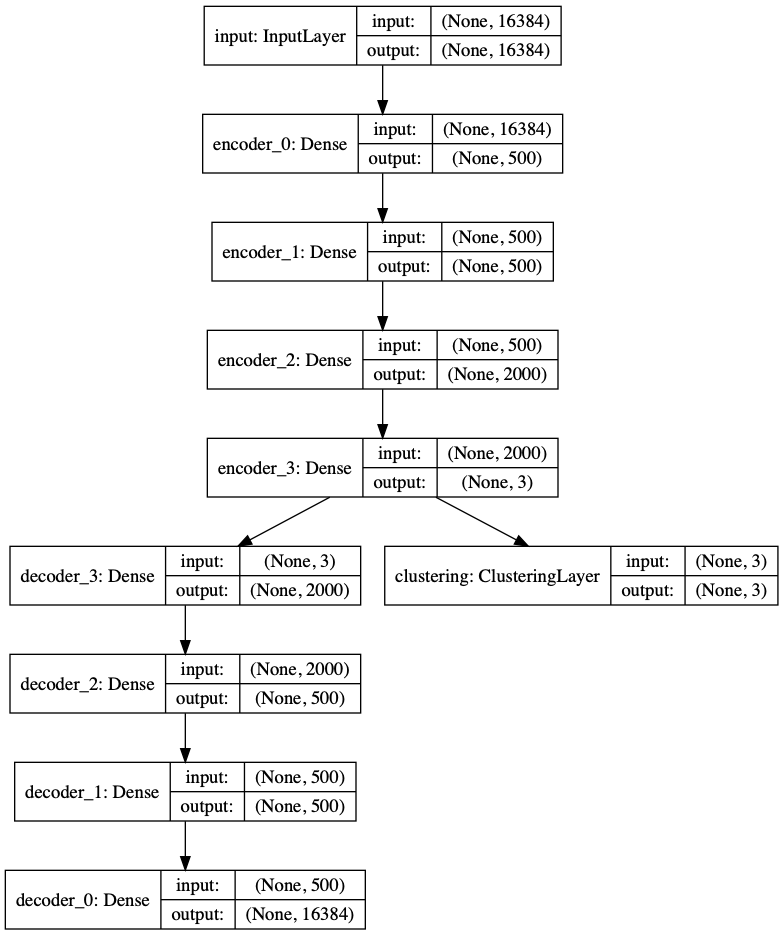

In [71]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [73]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [74]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [75]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

tol = 0.001 # tolerance threshold to stop training

## Training

In [81]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

Iter 0: acc = 0.36193, nmi = 0.00644, ari = 0.00098  ; loss= 0
Instructions for updating:
Use tf.cast instead.


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 140: acc = 0.37368, nmi = 0.00181, ari = -0.00285  ; loss= [0.03089 0.17517 0.01338]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 280: acc = 0.39953, nmi = 0.00000, ari = 0.00000  ; loss= [0.06807 0.293   0.03877]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 420: acc = 0.39953, nmi = 0.00000, ari = 0.00000  ; loss= [0.01929 0.      0.01929]
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


In [83]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

In [84]:
#eval
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.39953, nmi = 0.00000, ari = 0.00000  ; loss= [0.01929 0.      0.01929]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


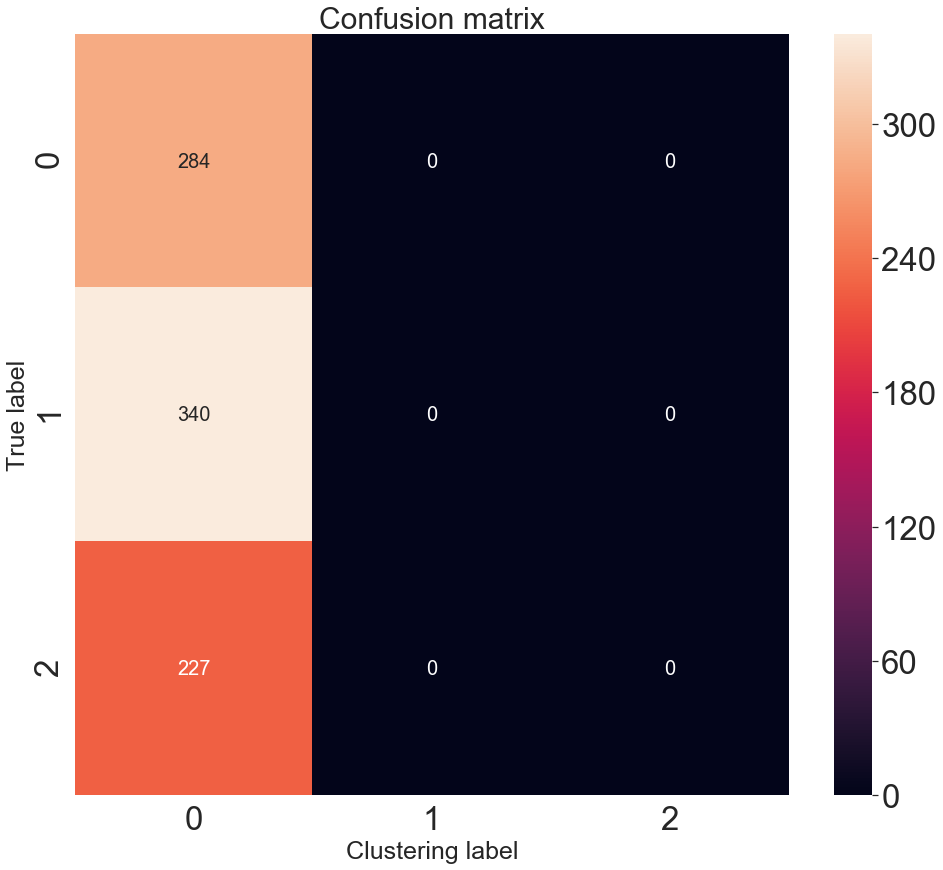

In [85]:
#confusion matrix
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)

confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y], y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()